In [96]:
import cv2
import numpy as np

img = cv2.imread("/home/sophieguan/proj-pete/test_images/image1.jpg")
labels = []
with open("/home/sophieguan/proj-pete/test_images/image1.txt") as file:
    labels = np.asarray([line.rstrip().split() for line in file], dtype='f')

img2 = cv2.imread("/home/sophieguan/proj-pete/test_images/image2.jpg")
labels2 = []
with open("/home/sophieguan/proj-pete/test_images/image2.txt") as file:
    labels2 = np.asarray([line.rstrip().split() for line in file], dtype='f')

In [97]:
labels

array([[1.      , 0.572201, 0.380701, 0.492375, 0.137264],
       [2.      , 0.436632, 0.445396, 0.436125, 0.118042]], dtype=float32)

In [98]:
labels2

array([[4.        , 0.5726563 , 0.65208334, 0.1375    , 0.14583333],
       [4.        , 0.446875  , 0.6215278 , 0.0921875 , 0.17638889]],
      dtype=float32)

In [99]:
def rescale(xc, yc, w, h, imw, imh):
    x1 = int((xc - w / 2) * imw)
    y1 = int((yc - h / 2) * imh)
    x2 = int((xc + w / 2) * imw)
    y2 = int((yc + h / 2) * imh)
    return x1, y1, x2, y2

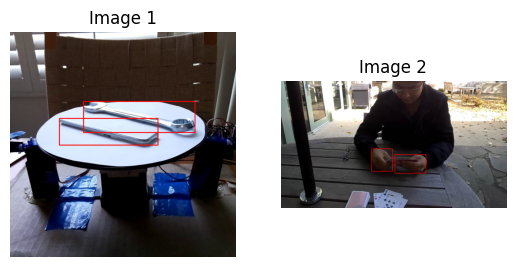

In [100]:
import matplotlib.pyplot as plt 

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for box in labels:
    x1, y1, x2, y2 = rescale(box[1], box[2], box[3], box[4], img_rgb.shape[1], img_rgb.shape[0])
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

for box in labels2:
    x1, y1, x2, y2 = rescale(box[1], box[2], box[3], box[4], img2_rgb.shape[1], img2_rgb.shape[0])
    cv2.rectangle(img2_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

fig, axes = plt.subplots(1, 2)

# Display the first image
axes[0].imshow(img_rgb)
axes[0].axis('off')
axes[0].set_title('Image 1')

# Display the second image
axes[1].imshow(img2_rgb)
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.show()

In [249]:
import random

def bbox_ioa2(box1, box2):
    # Returns the intersection over box2 area given box1, box2. box1 is 4, box2 is nx4. boxes are x1y1x2y2
    box2 = box2.transpose()

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]

    # Intersection area
    inter_area = (np.minimum(b1_x2, b2_x2) - np.maximum(b1_x1, b2_x1)).clip(0) * \
                 (np.minimum(b1_y2, b2_y2) - np.maximum(b1_y1, b2_y1)).clip(0)

    # box2 area
    box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1) + 1e-16

    # Intersection over box2 area
    return inter_area / box2_area

def bbox_ioa(box1, box2):
    # find ioa of box1 w.r.t. box2. Formatted as (x1, y1, x2, y2)
    left = max(box1[0], box2[0])
    right = min(box1[2], box2[2])
    bot = max(box1[1], box2[1])
    top = min(box1[3], box2[3])

    print(box1, box2)
    print(f"({left}, {right}, {top}, {bot})\n")
    if left < right and bot < top:
        ioa = (right - left) * (top - bot)
        b2a = (box2[2] - box2[0]) * (box2[3] - box2[1])
        return ioa / b2a
    else:
        return 0
        
def crop(image, a, b):
    h, w = image.shape[:2]
    if w < a or h < b:
        raise ValueError("img dimensions smaller than crop size")

    left = random.randint(0, w - a)
    top = random.randint(0, h - b)

    return image[top:top + b, left:left + a]

def cutmix(image, b, r_image, r_b):
        # modified from https://github.com/WongKinYiu/ScaledYOLOv4/issues/254
        boxes = b.copy()
        r_boxes = r_b.copy()
        # a bit of scaling for labels that are relative (i.e. a fraction of image size) instead of absolute
        if np.any(boxes < 1):
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = rescale(box[1], box[2], box[3], box[4], image.shape[1], image.shape[0])
                boxes[i] = [box[0], x1, y1, x2, y2]
        if np.any(r_boxes < 1):
            for i, box in enumerate(r_boxes):
                x1, y1, x2, y2 = rescale(box[1], box[2], box[3], box[4], r_image.shape[1], r_image.shape[0])
                r_boxes[i] = [box[0], x1, y1, x2, y2]
    
        cutmix_image = image.copy()
        imsize = min(image.shape[0], r_image.shape[0])

        # pick part of image1 to overlay image2
        x1, y1 = [int(random.uniform(imsize * 0.0, imsize * 0.45)) for _ in range(2)]
        x2, y2 = [int(random.uniform(imsize * 0.50, imsize * 0.8)) for _ in range(2)]
        
        cutmix_boxes = r_boxes.copy()
        area = (r_boxes[:, 3] - r_boxes[:, 1]) * (r_boxes[:, 4] - r_boxes[:, 2])

        # randomly select part of image2, plus shifting label boxes to match the selection
        left = random.randint(0, r_image.shape[1] - (x2-x1))
        top = random.randint(0, r_image.shape[0] - (y2-y1))
        cutmix_boxes[:, [1,3]] += x1 - left
        cutmix_boxes[:, [2,4]] += y1 - top
        
        cutmix_boxes[:, [1, 3]] = cutmix_boxes[:, [1, 3]].clip(min=x1, max=x2)
        cutmix_boxes[:, [2, 4]] = cutmix_boxes[:, [2, 4]].clip(min=y1, max=y2)
        cutmix_boxes = cutmix_boxes.astype(np.int32)
    
        #cropped w, h, area of r_image's bounding boxes
        w = cutmix_boxes[:, 3] - cutmix_boxes[:, 1]
        h = cutmix_boxes[:, 4] - cutmix_boxes[:, 2]
        area0 = w * h
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))
    
        # paste image2 onto image1
        cutmix_boxes = cutmix_boxes[np.where((w > 2) & (h > 2) & (area / (area0 + 1e-16) > 0) & (ar < 50))]
        # print(f"w={w}, h={h}, area={area}, area0={area0}, ar={ar}")
        cutmix_image[y1:y2, x1:x2] = r_image[top:top + (y2-y1), left:left + (x2-x1)]

        print(f"({x1}, {y1}, {x2}, {y2})")
        # calculate obstructions of image1's labels: if over threshold, then do not label
        obstructions = [bbox_ioa2(np.asarray([x1, y1, x2, y2]), box[1:]) for box in boxes]
        bu = []
        for i, obstruction in enumerate(obstructions):
            print(f"box {i + 1} ioa: {obstruction}")
            if obstruction < 0.95:
                bu.append(boxes[i])
        if len(bu) != 0: cutmix_boxes = np.concatenate((bu, cutmix_boxes), axis=0)
        return cutmix_image, cutmix_boxes

(171, 292, 536, 423)
box 1 ioa: 0.26638213117086357
box 2 ioa: 0.7980517047583364
num boxes: 4
	box 0: [  1. 234. 224. 589. 323.]
	box 1: [  2. 157. 278. 471. 363.]
	box 2: [  4. 260. 412. 436. 423.]
	box 3: [  4. 171. 379. 246. 423.]


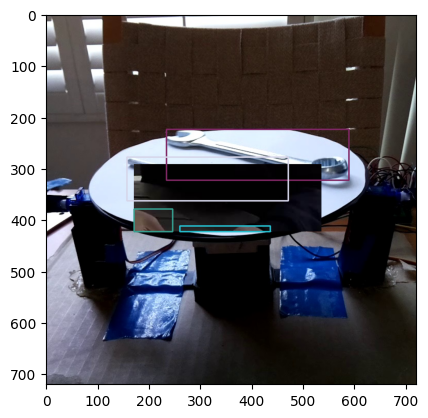

In [262]:
cutmix_img, cutmix_boxes = cutmix(img, labels, img2, labels2)
img_rgb = cv2.cvtColor(cutmix_img, cv2.COLOR_BGR2RGB)

print("num boxes:", len(cutmix_boxes))
for i, box in enumerate(cutmix_boxes):
    print(f"\tbox {i}: {box}")
    box = np.asarray(box, dtype=int)
    cv2.rectangle(img_rgb, (box[1], box[2]), (box[3], box[4]), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), 2)

# print(img2.shape)
plt.imshow(img_rgb)
plt.show()